In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
import heapq
import random
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Step 1

In [2]:
df = pd.read_csv("datasets/adult.csv")
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
df.shape, df.columns

((48842, 15),
 Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
        'marital-status', 'occupation', 'relationship', 'race', 'gender',
        'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
        'income'],
       dtype='object'))

In [4]:
df["income"].value_counts() # Target

income
<=50K    37155
>50K     11687
Name: count, dtype: int64

In [5]:
df["gender"].value_counts() # Sensitive Attr

gender
Male      32650
Female    16192
Name: count, dtype: int64

Reduce number of minorities

In [6]:
# new_df_m = df[df["gender"] == "Male"]
# new_df_f = df[df["gender"] == "Female"].sample(frac=0.1)
# df = pd.concat((new_df_f, new_df_m))
# df = df.sample(frac=1)
# df = df.reset_index()
# df.shape

(34269, 16)

In [7]:
# df["gender"].value_counts()

gender
Male      32650
Female     1619
Name: count, dtype: int64

Pre-process columns:
* Categorical
* Scale

Remove sensitive attribute.

### COMPAS

In [52]:
# For compas
df = df.drop(columns=['last','first','out_custody','in_custody','c_offense_date','decile_score.1','priors_count.1','c_case_number','days_b_screening_arrest','start','end','event','screening_date','c_case_number','juv_other_count','juv_misd_count','juv_fel_count','r_days_from_arrest','id','r_charge_degree','r_offense_date', 'vr_case_number','r_case_number','r_jail_out','c_arrest_date','r_charge_desc','r_jail_in', 'violent_recid','vr_charge_degree','vr_offense_date','vr_charge_desc'])
df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])
df['days_in_jail'] = abs((df['c_jail_out'] - df['c_jail_in']).dt.days)
df['compas_screening_date'] = pd.to_datetime(df['compas_screening_date'])
df['v_screening_date'] = pd.to_datetime(df['v_screening_date'])

/tmp/ipykernel_3426429/3600887003.py:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
/tmp/ipykernel_3426429/3600887003.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])
/tmp/ipykernel_3426429/3600887003.py:6: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['compas_screening_date'] = pd.to_datetime(df['compas_screening_date'])
/tmp/ipykernel_3426429/3600887003.py:7: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  

In [53]:
le = LabelEncoder()

columns = [
    'c_charge_degree', 
    'score_text', 
    'v_score_text', 
    'c_jail_in', 
    'c_jail_out', 
    'c_charge_desc', 
    'days_in_jail',
    'sex',
    'age_cat',
    'race'
]

df["compas_screening_date"] = pd.to_datetime(df["compas_screening_date"])
df["compas_screening_date"] = df['compas_screening_date'].apply(lambda x:x.toordinal())
df["dob"] = pd.to_datetime(df["dob"])
df["dob"] = df['dob'].apply(lambda x:x.toordinal())
df["v_screening_date"] = pd.to_datetime(df["v_screening_date"])
df["v_screening_date"] = df['v_screening_date'].apply(lambda x:x.toordinal())


for col in columns:
    df[col] = le.fit_transform(df[col])

for col in df.columns:
    df.dropna(inplace=True)

df.reset_index(inplace=True)

s = df["race"]
X = df.drop(columns=["race", "name", "type_of_assessment", "v_type_of_assessment", "v_score_text", "score_text", "index"])
y = df["score_text"]

X.head()

/tmp/ipykernel_3426429/3681283638.py:18: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["dob"] = pd.to_datetime(df["dob"])


,compas_screening_date,sex,dob,age,age_cat,decile_score,priors_count,c_jail_in,c_jail_out,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,is_violent_recid,v_decile_score,v_screening_date,days_in_jail
0,735094,1,710869,69,1,1,0,3207,2548,1.0,4,20,0,0,1,735094,0
1,735094,1,710869,69,1,1,0,3207,2548,1.0,4,20,0,0,1,735094,0
2,734895,1,723567,34,0,3,0,475,401,1.0,4,200,1,1,1,734895,10
3,734972,1,726966,24,2,4,4,1933,1401,1.0,4,369,1,0,3,734972,1
4,734972,1,726966,24,2,4,4,1933,1401,1.0,4,369,1,0,3,734972,1


### Adults

In [6]:
le = LabelEncoder()

adult_columns = ["workclass", 
           "education", 
           "marital-status", 
           "occupation", 
           "relationship", 
           "race", 
           "gender", 
           "native-country", 
           "income"]
# adults_drop = ["gender", "index"]
adults_drop = ["gender", "income"]

for col in adult_columns:
    df[col] = le.fit_transform(df[col])

s = df["gender"]
X = df.drop(columns=adults_drop)
y = df["income"]

X.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,capital-gain,capital-loss,hours-per-week,native-country
0,25,4,226802,1,7,4,7,3,2,0,0,40,39
1,38,4,89814,11,9,2,5,0,4,0,0,50,39
2,28,2,336951,7,12,2,11,0,4,0,0,40,39
3,44,4,160323,15,10,2,7,0,2,7688,0,40,39
4,18,0,103497,15,10,4,0,3,4,0,0,30,39


### Final

In [7]:
X = StandardScaler().fit_transform(X)
X.shape, y.shape

((48842, 13), (48842,))

# Step 2

Train a classifier on the dataset:
* LogisticRegression
* Simple NN (MLP)
* Decision Tree

TODO: Split to train/test and check the test score instead of train score.

In [8]:
indices = np.arange(len(X))
X_train, X_test, y_train, y_test, ind_train, ind_test = train_test_split(X, y, indices, test_size=0.33, random_state=0, shuffle=True, )
# clf = MLPClassifier(random_state=0, max_iter=300, verbose=1).fit(X, y)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
# clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
score = clf.score(X_test, y_test)
score

0.8200148901848865

Sort the points based on the accuracy of the classifier

In [9]:
scores = clf.predict_proba(X_test)[list(y_test.reset_index().index), y_test.to_list()]
scores.shape

(16118,)

In [10]:
BOTTOM_K_ERROR_REGION = 0.2 # The ratio of error region
ratio = int(BOTTOM_K_ERROR_REGION * len(scores))
err_region_ind = np.argpartition(scores, ratio)[:ratio]
err_region = scores[err_region_ind]
err_region.shape, scores.shape

((3223,), (16118,))

Visualize the error region in 2D

Text(0.5, 1.0, 'Demographic groups (Yellow is minority)')

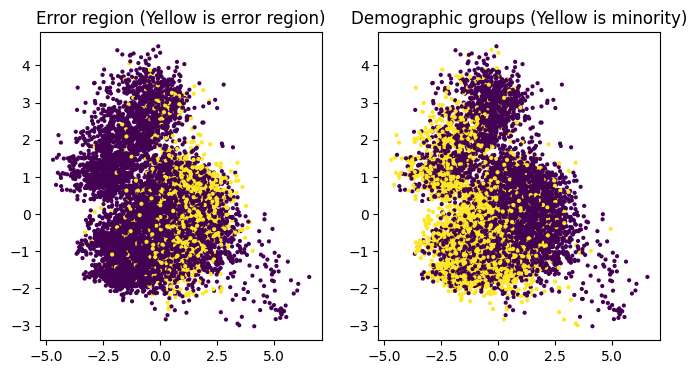

In [11]:
pca = PCA(n_components=2)
x_test_reduced = pca.fit_transform(X_test)
y_test_reduced = np.zeros(y_test.shape)
y_test_reduced[err_region_ind] = 1
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(x=x_test_reduced[:, 0], y=x_test_reduced[:, 1], c=y_test_reduced, s=4)
ax[0].set_title("Error region (Yellow is error region)")
ax[1].scatter(x=x_test_reduced[:, 0], y=x_test_reduced[:, 1], c=np.bitwise_not(s[ind_test]), s=4)
ax[1].set_title("Demographic groups (Yellow is minority)")

# Step 3
Find high skews

In [12]:
err_region_one_hot = np.zeros(y_test.shape)
err_region_one_hot[err_region_ind] = 1
np.unique(err_region_one_hot, return_counts=True)

(array([0., 1.]), array([12895,  3223]))

Approach

* Sample from the test data
* For each pair of points (a, b) in this sample, where a \in err_region and b \notin err_region calc skew
* Report highest skews

In [13]:
def skew(f, points):
    p_f = np.dot(points, f)
    mean = np.mean(p_f)
    sd = np.std(p_f)
    median = np.median(p_f)
    return ((mean - median) / sd)

def get_line(first_point, second_point):
    vec = second_point - first_point
    v_hat = vec / np.linalg.norm(vec)
    return v_hat

In [14]:
TEST_SAMPLE_RATIO = 0.05
X_test.shape, err_region_one_hot.shape

((16118, 13), (16118,))

In [15]:
ind_sample = np.random.choice(len(X_test), size=int(len(X_test) * TEST_SAMPLE_RATIO), replace=False)
sample_test = X_test[ind_sample]
sample_err = err_region_one_hot[ind_sample]
sample_test.shape, sample_err.shape, np.unique(sample_err, return_counts=True)

((805, 13), (805,), (array([0., 1.]), array([641, 164])))

In [16]:
err_reg_portion = sample_test[sample_err == 1]
not_err_reg_portion = sample_test[sample_err == 0]

heap = []
counter = 0
MAX = len(err_reg_portion)

for a in err_reg_portion:
    counter += 1
    print(f"{counter} / {MAX}")
    for b in not_err_reg_portion:
        f = get_line(a, b)
        sk = skew(f, X_train)
        heapq.heappush(heap, (-sk, tuple(f)))

1 / 164


2 / 164
3 / 164
4 / 164
5 / 164
6 / 164
7 / 164
8 / 164
9 / 164
10 / 164
11 / 164
12 / 164
13 / 164
14 / 164
15 / 164
16 / 164
17 / 164
18 / 164
19 / 164
20 / 164
21 / 164
22 / 164
23 / 164
24 / 164
25 / 164
26 / 164
27 / 164
28 / 164
29 / 164
30 / 164
31 / 164
32 / 164
33 / 164
34 / 164
35 / 164
36 / 164
37 / 164
38 / 164
39 / 164
40 / 164
41 / 164
42 / 164
43 / 164
44 / 164
45 / 164
46 / 164
47 / 164
48 / 164
49 / 164
50 / 164
51 / 164
52 / 164
53 / 164
54 / 164
55 / 164
56 / 164
57 / 164
58 / 164
59 / 164
60 / 164
61 / 164
62 / 164
63 / 164
64 / 164
65 / 164
66 / 164
67 / 164
68 / 164
69 / 164
70 / 164
71 / 164
72 / 164
73 / 164
74 / 164
75 / 164
76 / 164
77 / 164
78 / 164
79 / 164
80 / 164
81 / 164
82 / 164
83 / 164
84 / 164
85 / 164
86 / 164
87 / 164
88 / 164
89 / 164
90 / 164
91 / 164
92 / 164
93 / 164
94 / 164
95 / 164
96 / 164
97 / 164
98 / 164
99 / 164
100 / 164
101 / 164
102 / 164
103 / 164
104 / 164
105 / 164
106 / 164
107 / 164
108 / 164
109 / 164
110 / 164
111 / 164
112 / 

In [17]:
def get_high_skews(heap, top_k=10):
        count = 0
        heap = heap.copy()
        while True:
            count = count + 1
            try:
                yield heapq.heappop(heap)
                if count == top_k:
                    break
            except:
                break

top_skews = list(get_high_skews(heap, top_k=5))

Visualize high skewed directions

In [18]:
gender = s[ind_train]

In [19]:
gender.value_counts()

gender
1    21918
0    10806
Name: count, dtype: int64

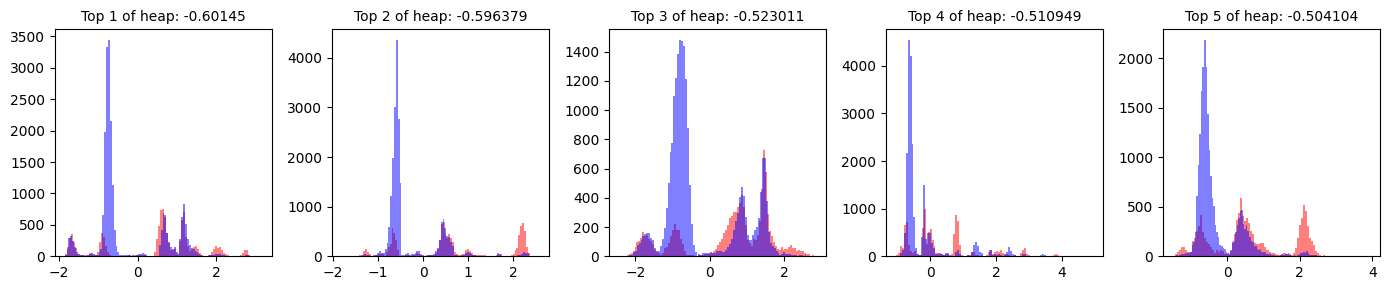

In [20]:
fig, axs = plt.subplots(1, len(top_skews), figsize=(14, 3))
ind = 0
for ax in axs:
    ax.hist(np.dot(X_train[gender == 0], top_skews[ind][1]), color="red", alpha=0.5, bins=100, label="Female")
    ax.hist(np.dot(X_train[gender != 0], top_skews[ind][1]), color="blue", alpha=0.5, bins=100, label="Male")
    ax.set_title(f"Top {ind + 1} of heap: {round(top_skews[ind][0], 6)}", fontsize=10)
    ind += 1
plt.tight_layout()

# Step 3

Report problematic points from the tail.

* Given a percentile as hyper-parameter, find the tail on X_train
* Among the points on the tail, report the most problematic ones

In [21]:
TAIL_PERCENTILE = 0.01 # Percentile of points as tail
SCORE_RATIO = 0.05 # Error region ratio in X_train

In [22]:
def get_demo_ratio(arr, min):
    uniq, counts = np.unique(arr, return_counts=True)

    min_count = 0
    try:
        min_count = counts[uniq == min][0]
    except:
        pass

    maj_count = 0
    try:
        maj_count = np.sum(counts)
    except:
        pass

    return min_count / max(maj_count, 0.1)

In [25]:
results = {
    "top_skew": [], # Which highest skew (1st, 2nd, ...)
    "total_demo_ratio": [], # Demographic ratio of minorities
    "tail_demo_ratio": [], # Demographic ratio of minorities on the tail
    "tail_percentile": [], # The percentile used as tail
    "min_avg_tail_score": [], # Average score of minorities on tail
    "maj_avg_tail_score": [], # Average score of majoroties on tail
    "total_avg_tail_score": [], # Score on the tail of direction
    "score_ratio": [], # k: Top-K errors on the tail to report as the problematic points
    "tail_err_demo_ratio": [] # Ratio of demographic groups in the problematic points of the tail
}

min_label = 0

counter = 0
for (_, f) in top_skews:
    print(f"Highest {counter + 1} skew")
    counter += 1

    tmp = np.dot(X_train, f)
    sk = (np.mean(tmp) - np.median(tmp)) / np.std(tmp)

    q1 = np.quantile(tmp, TAIL_PERCENTILE if sk < 0 else (1 - TAIL_PERCENTILE))
    tail_ind = np.apply_along_axis(lambda r: np.dot(r, f) < q1 if sk < 0 else np.dot(r, f) > q1, 1, X_train)
    tail = X_train[tail_ind]

    print("Tail demographics: ")
    print(pd.DataFrame(gender[tail_ind]).value_counts())
    print("Over all demographics: ")
    print(gender.value_counts())

    fem_tail = X_train[tail_ind][gender[tail_ind] == min_label]
    ml_tail = X_train[tail_ind][gender[tail_ind] != min_label]

    
    fem_scores = clf.predict_proba(fem_tail)[list(y_train[tail_ind][gender[tail_ind] == min_label].reset_index().index), y_train[tail_ind][gender[tail_ind] == min_label].to_list()] if fem_tail.shape[0] > 0 else 0
    ml_scores = clf.predict_proba(ml_tail)[list(y_train[tail_ind][gender[tail_ind] != min_label].reset_index().index), y_train[tail_ind][gender[tail_ind] != min_label].to_list()] if ml_tail.shape[0] > 0 else 0
    scores = clf.predict_proba(X_train[tail_ind])[list(y_train[tail_ind].reset_index().index), y_train[tail_ind].to_list()]

    print("Fem average score in tail: ", np.mean(fem_scores))
    print("Male average score in tail: ", np.mean(ml_scores))
    print("Total Tail Score: ", np.mean(scores))

    for sr in [0.8, 0.5, 0.2, 0.1, 0.05, 0.01]:
        print("Score Ratio: ", sr)

        scores = clf.predict_proba(X_train[tail_ind])[list(y_train[tail_ind].reset_index().index), y_train[tail_ind].to_list()]
        ratio = int(sr * len(scores))
        err_region_ind = np.argpartition(scores, ratio)[:ratio]
        err_region = scores[err_region_ind]
        
        g = gender[tail_ind].to_numpy()[err_region_ind]
        print("Demographics in the error region:")
        print(pd.DataFrame(g).value_counts())

        results["top_skew"].append(counter)
        results["tail_demo_ratio"].append(get_demo_ratio(gender[tail_ind], min_label))
        results["total_demo_ratio"].append(get_demo_ratio(gender, min_label))
        results["tail_percentile"].append(TAIL_PERCENTILE)
        results["maj_avg_tail_score"].append(np.mean(ml_scores))
        results["min_avg_tail_score"].append(np.mean(fem_scores))
        results["total_avg_tail_score"].append(np.mean(scores))
        results["score_ratio"].append(sr)
        results["tail_err_demo_ratio"].append(get_demo_ratio(g, min_label))
        
        print("Results")
        for k in results:
            print(k, results[k][-1])


Highest 1 skew
Tail demographics: 
gender
0         277
1          51
Name: count, dtype: int64
Over all demographics: 
gender
1    21918
0    10806
Name: count, dtype: int64
Fem average score in tail:  0.9094499157446909
Male average score in tail:  0.8233457237614354
Total Tail Score:  0.8960617639424163
Score Ratio:  0.8
Demographics in the error region:
0
0    222
1     40
Name: count, dtype: int64
Results
top_skew 1
total_demo_ratio 0.33021635496883023
tail_demo_ratio 0.8445121951219512
tail_percentile 0.01
min_avg_tail_score 0.9094499157446909
maj_avg_tail_score 0.8233457237614354
total_avg_tail_score 0.8960617639424163
score_ratio 0.8
tail_err_demo_ratio 0.8473282442748091
Score Ratio:  0.5
Demographics in the error region:
0
0    137
1     27
Name: count, dtype: int64
Results
top_skew 1
total_demo_ratio 0.33021635496883023
tail_demo_ratio 0.8445121951219512
tail_percentile 0.01
min_avg_tail_score 0.9094499157446909
maj_avg_tail_score 0.8233457237614354
total_avg_tail_score 0.89

In [26]:
# pd.DataFrame(results).to_csv("adults_exp_1.csv")

# Visualize Results

In [2]:
results = pd.read_csv("adults_exp_1.csv", index_col=0)
results.head()

,top_skew,total_demo_ratio,tail_demo_ratio,tail_percentile,min_avg_tail_score,maj_avg_tail_score,total_avg_tail_score,score_ratio,tail_err_demo_ratio
0,1,0.330216,0.844512,0.01,0.90945,0.823346,0.896062,0.80,0.847328
1,1,0.330216,0.844512,0.01,0.90945,0.823346,0.896062,0.50,0.835366
2,1,0.330216,0.844512,0.01,0.90945,0.823346,0.896062,0.20,0.753846
3,1,0.330216,0.844512,0.01,0.90945,0.823346,0.896062,0.10,0.625000
4,1,0.330216,0.844512,0.01,0.90945,0.823346,0.896062,0.05,0.750000


The ratio of minorities given different bottom k accuracies on tail.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


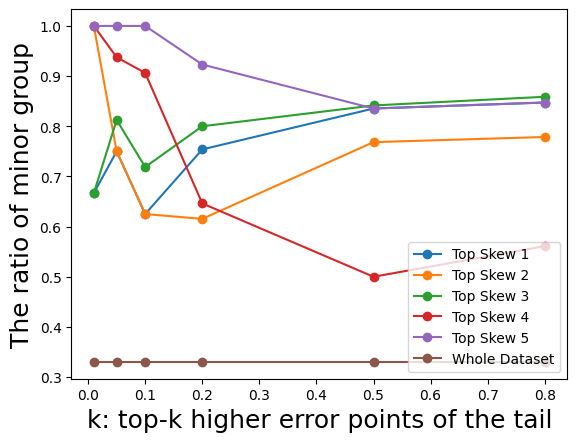

In [25]:
markers = ["o", "o", "o", "o", "o"]
for i in range(5):
    plt.plot(results[results["top_skew"] == i + 1]["score_ratio"], results[results["top_skew"] == i + 1]["tail_err_demo_ratio"], marker=markers[i], label=f"Top Skew {i + 1}")
plt.plot(results[results["top_skew"] == 1]["score_ratio"], results[results["top_skew"] == 1]["total_demo_ratio"], marker="o", label="Whole Dataset")
plt.ylabel("The ratio of minor group", fontsize=18)
plt.xlabel("k: top-k higher error points of the tail", fontsize=18)
plt.legend(fontsize=10, loc="lower right")
# plt.savefig("adults_region.eps", format="eps")

In [39]:
# Model score = 0.82
results.groupby("top_skew").mean()[["total_avg_tail_score", "min_avg_tail_score", "maj_avg_tail_score"]]

,total_avg_tail_score,min_avg_tail_score,maj_avg_tail_score
top_skew,,,
1,0.896062,0.909450,0.823346
2,0.813582,0.827329,0.763818
3,0.909436,0.916654,0.867330
4,0.780287,0.755071,0.813730
5,0.726513,0.715182,0.786654
